In [66]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [2]:
os.listdir()

['test_data.csv',
 'sample_submission.csv',
 'train_data.csv',
 'submis_automl.csv',
 'auto_ml.ipynb',
 'gbmodel.ipynb']

In [11]:
df_train = pd.read_csv('train_data.csv', index_col='row_ID')
df_test = pd.read_csv('test_data.csv', index_col='row_ID')
df_train.head()

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
row_ID,,,,,,,,,,,,,,
0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [12]:
df_test.head()

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
row_ID,,,,,,,,,,,,,
35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 0 to 34999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vehicle_manufacturer    34999 non-null  object 
 1   vehicle_model           34993 non-null  object 
 2   vehicle_category        34999 non-null  object 
 3   current_mileage         35000 non-null  int64  
 4   vehicle_year            35000 non-null  int64  
 5   vehicle_gearbox_type    34999 non-null  object 
 6   doors_cnt               34255 non-null  object 
 7   wheels                  34999 non-null  object 
 8   vehicle_color           34599 non-null  object 
 9   vehicle_interior_color  28282 non-null  object 
 10  car_vin                 11488 non-null  object 
 11  car_leather_interior    35000 non-null  int64  
 12  deal_type               35000 non-null  object 
 13  final_price             35000 non-null  float64
dtypes: float64(1), int64(3), object(10)
me

# EDA

In [14]:
df_train.shape, df_test.shape

((35000, 14), (10697, 13))

In [18]:
# Drop duplicates
df_train.drop_duplicates(inplace=True)
df_train.shape

(26928, 14)

In [19]:
df_train.isnull().sum()

vehicle_manufacturer          1
vehicle_model                 7
vehicle_category              1
current_mileage               0
vehicle_year                  0
vehicle_gearbox_type          1
doors_cnt                   370
wheels                        1
vehicle_color               146
vehicle_interior_color     2007
car_vin                   22040
car_leather_interior          0
deal_type                     0
final_price                   0
dtype: int64

In [20]:
df_test.isnull().sum()

vehicle_manufacturer         1
vehicle_model                2
vehicle_category             1
current_mileage              0
vehicle_year                 0
vehicle_gearbox_type         1
doors_cnt                  223
wheels                       1
vehicle_color              134
vehicle_interior_color    2078
car_vin                   7131
car_leather_interior         0
deal_type                    0
dtype: int64

In [42]:
X = df_train.iloc[:, :-1]
y  = df_train.iloc[:, -1]

In [43]:
def sel_col(X, uni_col=15, all_col=False):
    if all_col:
        col_list = [x for x in X.select_dtypes(include='object').columns]
    else:
        col_list = [x for x in X.select_dtypes(include='object').columns if X[x].nunique() < uni_col]
    num_list = [x for x in X.select_dtypes(include=['int64', 'float64']).columns]
    return col_list, num_list

In [44]:
col_list, num_list = sel_col(X, all_col=True)

In [47]:
num_list

['current_mileage', 'vehicle_year', 'car_leather_interior']

In [45]:
df_cat = X[col_list]

In [49]:
ordin = OrdinalEncoder()
df_cat = pd.DataFrame(ordin.fit_transform(df_cat), index=df_cat.index, columns=df_cat.columns)

In [50]:
X_full = pd.concat([df_cat, X[num_list]], axis=1)
X_full

,vehicle_manufacturer,vehicle_model,vehicle_category,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,deal_type,current_mileage,vehicle_year,car_leather_interior
row_ID,,,,,,,,,,,,,
0,61.0,366.0,9.0,0.0,1.0,1.0,12.0,1.0,NaN,1.0,133000,2014,0
1,37.0,455.0,9.0,1.0,1.0,0.0,12.0,1.0,NaN,1.0,24500,2010,0
2,23.0,2046.0,3.0,2.0,0.0,0.0,12.0,1.0,3359.0,1.0,31000,2016,1
3,23.0,1817.0,4.0,0.0,1.0,0.0,2.0,1.0,NaN,1.0,115459,2015,1
4,61.0,525.0,4.0,0.0,1.0,0.0,1.0,NaN,3109.0,1.0,18950,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34994,6.0,1749.0,9.0,0.0,1.0,0.0,12.0,1.0,NaN,1.0,229677,2011,1
34995,16.0,1038.0,9.0,0.0,1.0,0.0,1.0,NaN,732.0,1.0,87579,2013,1
34996,56.0,1704.0,4.0,0.0,1.0,0.0,12.0,1.0,NaN,1.0,116092,2009,1


In [52]:
X_full.isnull().sum()

vehicle_manufacturer          1
vehicle_model                 7
vehicle_category              1
vehicle_gearbox_type          1
doors_cnt                   370
wheels                        1
vehicle_color               146
vehicle_interior_color     2007
car_vin                   22040
deal_type                     0
current_mileage               0
vehicle_year                  0
car_leather_interior          0
dtype: int64

In [61]:
X_full.fillna(0, inplace=True)

<AxesSubplot:>

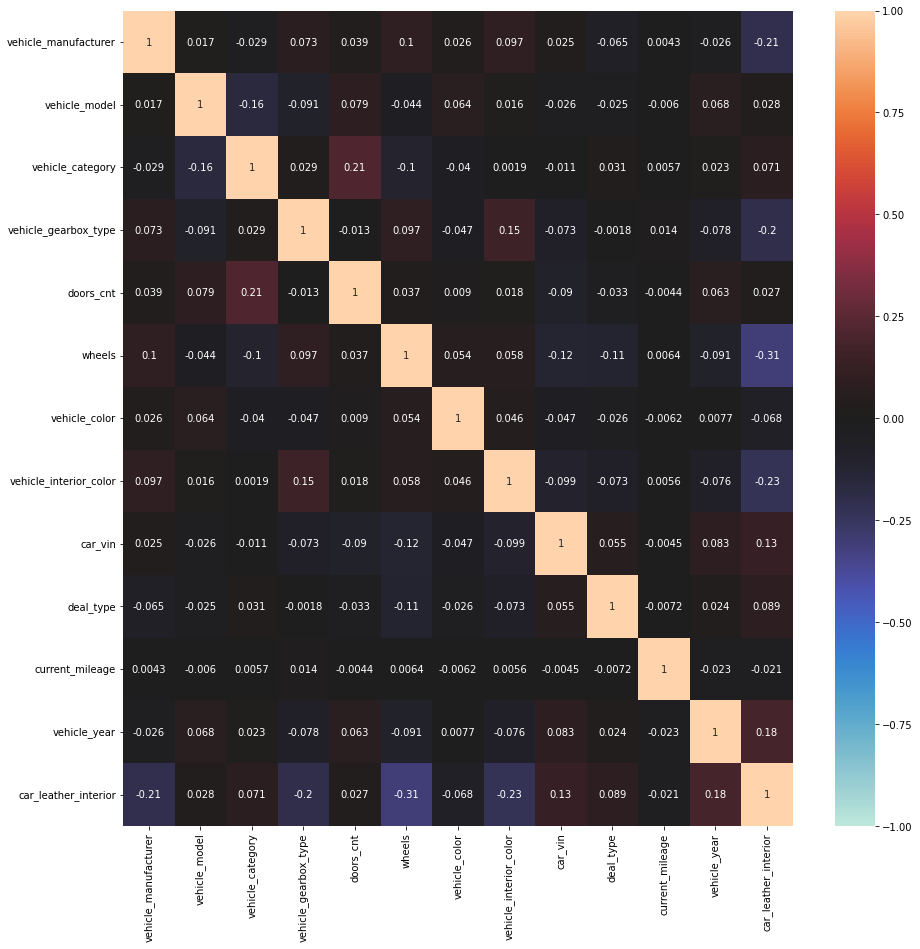

In [76]:
plt.figure(figsize=(15,15))
sns.heatmap(X_full.corr(), annot=True, vmin=-1, center=0)

In [79]:
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, train_size=0.7, random_state=35)

In [93]:
lin_model = LinearRegression()

In [96]:
las_model = Lasso()

In [94]:
sc = StandardScaler()

In [95]:
X_train_sc = sc.fit_transform(X_train)

In [106]:
result = cross_val_score(las_model, X_train_sc, y_train, scoring='neg_mean_absolute_error')

In [107]:
result.mean()

-5373.398756528656

In [108]:
rf_model = RandomForestRegressor()

In [112]:
param = {'n_estimators': [50,100,150,200,250,300], 'max_depth': [2,3,4,5,6]}
gbm_param = {'model__loss':['ls', 'lad'], 'model__learning_rate': [0.01, 0.1, 1.0], 'model__n_estimators':[50,100,150,200], 'model__max_depth':[2,3,4]}

In [114]:
search = GridSearchCV(rf_model, param, n_jobs=-1, scoring='neg_mean_absolute_error')
search.fit(X_train_sc, y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='neg_mean_absolute_error')

In [115]:
search.best_score_

-5089.8430924880195

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_list),
        ('cat', categorical_transformer, col_list)
    ])


In [ ]:
# Keep selected columns only
"""my_cols = col_list + num_list
X_train = X[my_cols].copy()
X_valid = df_test[my_cols].copy()"""

In [14]:
def select_col(df):
    categorical_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
    numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
    return categorical_cols, numerical_cols

In [25]:
X.head()

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type
row_ID,,,,,,,,,,,,
0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,0,For Sale
1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,0,For Sale
2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,1,For Sale
3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,1,For Sale
4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,1,For Sale


In [29]:
cat_cols, num_cols = select_col(X)

In [30]:
cat_cols

['vehicle_manufacturer',
 'vehicle_model',
 'vehicle_category',
 'vehicle_gearbox_type',
 'doors_cnt',
 'wheels',
 'vehicle_color',
 'vehicle_interior_color',
 'deal_type']

In [31]:
num_cols

['current_mileage', 'vehicle_year', 'car_leather_interior']

In [33]:
X_cat = X[cat_cols]

In [36]:
X_cat.nunique()

vehicle_manufacturer        68
vehicle_model             2224
vehicle_category            11
vehicle_gearbox_type         4
doors_cnt                    3
wheels                       2
vehicle_color               16
vehicle_interior_color      11
deal_type                    2
dtype: int64